# Statistical analysisa and examples

In [8]:
import sys
sys.path.append('../common')
from utils import weight3 as weight_fn, weight_by_index
from utils import bag_weight, score, mean_n_sigma, score_stats
from utils import MAX_WEIGHT, AVAILABLE_GIFTS, GIFT_TYPES, N_TYPES, N_BAGS

from copy import deepcopy
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Find optimal number of a single gift in the bag for a given rejection probability.

21
(991, 0.099099999999999994)
(21, 36.741931190640969, 367419.31190640968, 0.099099999999999994)
(22, 34.369119007526962, 343691.19007526961, 0.1797)
(20, 37.656170183966566, 376561.70183966565, 0.044400000000000002)
(19, 37.144666923114507, 371446.66923114506, 0.016199999999999999)


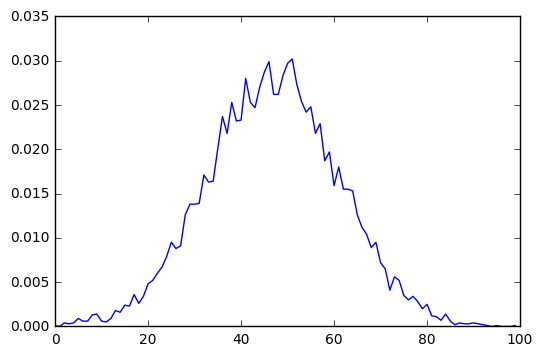

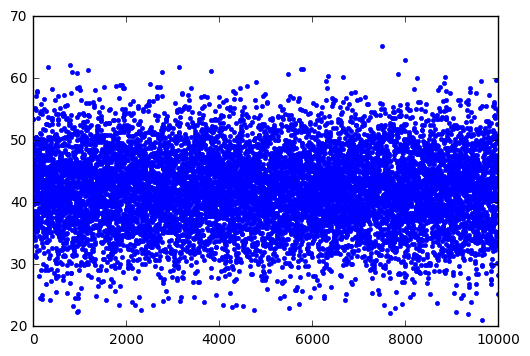

In [2]:
index = 0
weights = np.array([weight_by_index(index) for i in range(10000)])
hist = np.histogram(weights, bins=2*MAX_WEIGHT)

pdf = hist[0] *1.0 / np.sum(hist[0])
x = hist[1][:-1]

plt.figure()
plt.plot(pdf)

def find_n(pdf, x, epsilon=0.1):
    for n in range(1, 1000):
        y = MAX_WEIGHT * 1.0 / n
        res = np.where(x > y)[0]
        if len(res) > 0:
            index = res[0]
            pr = np.sum(pdf[index:])
            if pr > epsilon:
                return n-1
            
n = find_n(pdf, x, epsilon=0.1)
print(n)

print(np.sum(weights * n > MAX_WEIGHT), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

plt.figure()
plt.plot(weights * n, '.')


nweights = deepcopy(weights)
nweights[weights * n > MAX_WEIGHT] = 0.0
print(n, np.sum(nweights * n) * 1.0 / len(nweights), np.sum(nweights * n), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

n += 1
nweights = deepcopy(weights)
nweights[weights * n > MAX_WEIGHT] = 0.0
print(n, np.sum(nweights * n) * 1.0 / len(nweights), np.sum(nweights * n), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

n -= 2
nweights = deepcopy(weights)
nweights[weights * n > MAX_WEIGHT] = 0.0
print(n, np.sum(nweights * n) * 1.0 / len(nweights), np.sum(nweights * n), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

n -= 1
nweights = deepcopy(weights)
nweights[weights * n > MAX_WEIGHT] = 0.0
print(n, np.sum(nweights * n) * 1.0 / len(nweights), np.sum(nweights * n), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

Single gift optimization

In [15]:
N_TRIALS = 10000
GIFT_WEIGHTS = np.zeros((N_TRIALS, N_TYPES))
for index in range(N_TYPES):
    GIFT_WEIGHTS[:, index] = [weight_by_index(index) for i in range(10000)]

In [18]:
def find_n(weights):
    best_mean_score = 0
    best_n = 0
    for n in range(1, 100):
        mask = weights * n < MAX_WEIGHT
        if not mask.any():
            break
        score = np.sum(weights[mask] * n) * 1.0 / len(weights)  
        if score > best_mean_score:
            best_mean_score = score
            best_n = n
            
    return best_n, best_mean_score

LIMIT_NB_GIFTS = np.zeros((N_TYPES), dtype=np.uint8)

for index in range(N_TYPES):
    n, s = find_n(GIFT_WEIGHTS[:,index])
    print GIFT_TYPES[index], index, n, s
    LIMIT_NB_GIFTS[index] = n


# print(np.sum(weights * n > MAX_WEIGHT), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

# nweights = deepcopy(weights)
# nweights[weights * n > MAX_WEIGHT] = 0.0
# print(n, np.sum(nweights * n) * 1.0 / len(nweights), np.sum(nweights * n), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

# n += 1
# nweights = deepcopy(weights)
# nweights[weights * n > MAX_WEIGHT] = 0.0
# print(n, np.sum(nweights * n) * 1.0 / len(nweights), np.sum(nweights * n), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

# n -= 2
# nweights = deepcopy(weights)
# nweights[weights * n > MAX_WEIGHT] = 0.0
# print(n, np.sum(nweights * n) * 1.0 / len(nweights), np.sum(nweights * n), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

# n -= 1
# nweights = deepcopy(weights)
# nweights[weights * n > MAX_WEIGHT] = 0.0
# print(n, np.sum(nweights * n) * 1.0 / len(nweights), np.sum(nweights * n), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

ball 0 20 37.5265983078
bike 1 2 20.8420273871
blocks 2 3 30.8743842129
book 3 15 15.0556780015
coal 4 1 23.3694727133
doll 5 7 25.2419626719
gloves 6 50 17.6565583927
horse 7 6 27.5197944368
train 8 3 25.0216282136


In [20]:
LIMIT_NB_GIFTS, np.prod(LIMIT_NB_GIFTS)

(array([20,  2,  3, 15,  1,  7, 50,  6,  3], dtype=uint8), 11340000)

## Multi-gift optimization

In [4]:
n_trials = 10000
weights = np.zeros((n_trials, N_TYPES))
for index in range(N_TYPES):
    weights[:, index] = [weight_by_index(index) for i in range(10000)]

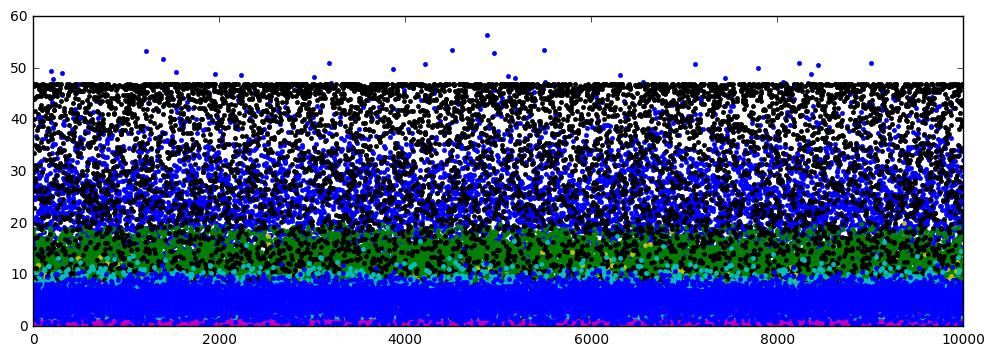

In [5]:
plt.figure(figsize=(12,4))    
colors = ['r','b','g','y','k','c','m','']
for index in range(N_TYPES-1):    
    plt.plot(weights[:, index], '.'+colors[index])

In [14]:
def compute_score(state):
    s = np.sum(GIFT_WEIGHTS * state, axis=1)
    mask = s < MAX_WEIGHT
    rejected = (N_TRIALS - np.sum(mask))*1.0 / N_TRIALS
    score = np.sum(s[mask]) * 1.0 / N_TRIALS
    return score, rejected


state = np.zeros((N_TYPES), dtype=np.uint8)
state[1] = 2
compute_score(state)

(20.770146778268025, 0.30709999999999998)

In [9]:
filled_bags = np.zeros((N_BAGS, N_TYPES), dtype=np.uint8)
available_gifts = deepcopy(AVAILABLE_GIFTS)
bag_index = 0
found_goal_states = []

In [10]:
alpha = 0.745
goal_weight = MAX_WEIGHT * alpha
print goal_weight

37.25


In [11]:
# available_gifts['ball'] = 0
available_gifts

{'ball': 1100,
 'bike': 500,
 'blocks': 1000,
 'book': 1200,
 'coal': 166,
 'doll': 1000,
 'gloves': 200,
 'horse': 1000,
 'train': 1000}

In [40]:
LIMIT_NB_GIFTS

array([20,  2,  3, 15,  1,  7, 50,  6,  3], dtype=uint8)

In [55]:
ll = np.prod(LIMIT_NB_GIFTS)
scores = np.zeros((ll, 2))
counter = [0]

In [56]:
def huge_loop(scores, counter):
    for n0 in range(LIMIT_NB_GIFTS[0]):
        print "n0: ", n0, "/", LIMIT_NB_GIFTS[0]
        for n1 in range(LIMIT_NB_GIFTS[1]):
            print "n1: ", n1, "/", LIMIT_NB_GIFTS[1]
            for n2 in range(LIMIT_NB_GIFTS[2]):
                for n3 in range(LIMIT_NB_GIFTS[3]):
                    for n4 in range(LIMIT_NB_GIFTS[4]):
                        for n5 in range(LIMIT_NB_GIFTS[5]):
                            for n6 in range(LIMIT_NB_GIFTS[6]):
                                for n7 in range(LIMIT_NB_GIFTS[7]):
                                    for n8 in range(LIMIT_NB_GIFTS[8]):
                                        state = np.array([n0, n1, n2, n3, n4, n5, n6, n7, n8])
                                        scores[counter[0], :] = compute_score(state)
                                        counter[0] += 1
    return scores

In [57]:
huge_loop(scores, counter)

n0:  0 / 20
n1:  0 / 2
n1:  1 / 2
n0:  1 / 20
n1:  0 / 2
n1:  1 / 2
n0:  2 / 20
n1:  0 / 2
n1:  1 / 2
n0:  3 / 20
n1:  0 / 2
n1:  1 / 2
n0:  4 / 20
n1:  0 / 2
n1:  1 / 2
n0:  5 / 20
n1:  0 / 2
n1:  1 / 2
n0:  6 / 20
n1:  0 / 2
n1:  1 / 2
n0:  7 / 20
n1:  0 / 2
n1:  1 / 2
n0:  8 / 20
n1:  0 / 2
n1:  1 / 2
n0:  9 / 20
n1:  0 / 2
n1:  1 / 2
n0:  10 / 20
n1:  0 / 2
n1:  1 / 2
n0:  11 / 20
n1:  0 / 2
n1:  1 / 2
n0:  12 / 20
n1:  0 / 2
n1:  1 / 2
n0:  13 / 20
n1:  0 / 2
n1:  1 / 2
n0:  14 / 20
n1:  0 / 2
n1:  1 / 2
n0:  15 / 20
n1:  0 / 2
n1:  1 / 2
n0:  16 / 20
n1:  0 / 2
n1:  1 / 2
n0:  17 / 20
n1:  0 / 2
n1:  1 / 2
n0:  18 / 20
n1:  0 / 2
n1:  1 / 2
n0:  19 / 20
n1:  0 / 2
n1:  1 / 2


array([[  0.00000000e+00,   0.00000000e+00],
       [  1.01004825e+01,   0.00000000e+00],
       [  2.01062395e+01,   1.80000000e-03],
       ..., 
       [  0.00000000e+00,   1.00000000e+00],
       [  0.00000000e+00,   1.00000000e+00],
       [  0.00000000e+00,   1.00000000e+00]])

In [58]:
# Save result
np.save("scores.npy", scores)

In [61]:
mask = scores > MAX_WEIGHT*0.745
len(scores[mask]), scores[mask]

(88, array([ 37.40811079,  37.56520949,  37.38235361,  37.85723887,
         37.52219788,  37.44198278,  37.94454495,  37.85401923,
         37.70922373,  37.60580225,  38.3040878 ,  38.31925526,
         37.30588939,  37.90665548,  37.46554326,  37.51345527,
         37.62709685,  38.44112215,  37.34334819,  37.55057761,
         37.46598068,  37.71051689,  38.13465804,  37.25654115,
         37.53549755,  37.88065167,  37.98499032,  38.5344257 ,
         37.61695539,  37.79771871,  38.23434405,  38.37410629,
         37.96297356,  38.03855375,  37.6855508 ,  37.35097706,
         37.3487231 ,  38.71874416,  38.18261552,  38.47839485,
         37.86064765,  37.81662081,  37.68970805,  37.43558154,
         37.41142858,  37.28847938,  37.6705844 ,  38.03997259,
         38.0040332 ,  37.45520482,  37.67475184,  38.03558806,
         37.96813335,  37.38043305,  37.35032217,  37.98280762,
         37.31044523,  37.37945923,  37.96657295,  37.78432016,
         38.3281171 ,  38.16222281, 

In [65]:
def has_min_nb_gifts(state):
    return np.sum(state) >= 3 

In [70]:
has_min_nb_gifts(np.array([1,1,1,0,0,5,0,0]))

True